# Uncertainty Propagation

This example aims at introducing some basics of uncertainty propagation with OpenTURNS. 

In [1]:
import numpy as np
import openturns as ot
from openturns.viewer import View
import pylab as pl
%pylab --no-import-all inline

Populating the interactive namespace from numpy and matplotlib


# Definition of the probabilistic model of input variables

Let first define the marginal (univariate) distribution of each variable.

In [2]:
sample_E = ot.NumericalSample.ImportFromCSVFile("sample_E.csv") 
kernel_smoothing = ot.KernelSmoothing(ot.Normal())
bandwidth = kernel_smoothing.computeSilvermanBandwidth(sample_E)
E = kernel_smoothing.build(sample_E, bandwidth)
E.setDescription(['Young modulus'])

In [3]:
F = ot.LogNormal()
F.setParameter(ot.LogNormalMuSigma()([30000, 9000, 15000]))
F.setDescription(['Load'])

In [4]:
L = ot.Uniform(250, 260)
L.setDescription(['Length'])

In [5]:
I = ot.Beta(2.5, 4, 310, 450)
I.setDescription(['Inertia'])

We now fix the order of the marginal distributions in the joint distribution. Order must match in the implementation of the physical model (to come).

In [6]:
marginal_distributions = [F, E, L, I]

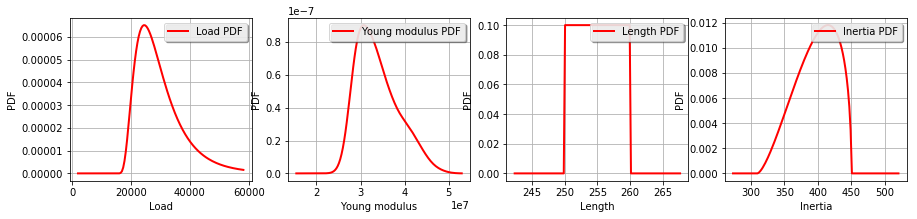

In [7]:
fig = pl.figure(figsize=(15, 3))
drawables = [marginal_distribution.drawPDF() for marginal_distribution in marginal_distributions]
axes = [fig.add_subplot(1, 4, i) for i in range(1, 5)]
for axis, drawable in zip(axes, drawables):
    _ = View(drawable, figure=fig, axes=[axis])

Let then define the dependence structure as a Normal copula with a single non-zero Spearman correlation between components 2 and 3 of the final random vector, that is $L$ and $I$.

In [8]:
SR_cor = ot.CorrelationMatrix(len(marginal_distributions))
SR_cor[2, 3] = -0.2
copula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(SR_cor))

Eventually the input joint distribution is defined as a *composed distribution*.

In [9]:
X_distribution = ot.ComposedDistribution(marginal_distributions, copula)

# Definition of the physical model

First, let us define a Python function that implements the model $\mathcal{M}: \mathbf{x} \mapsto \mathbf{y}$.

Either as an analytical function:

In [10]:
model = ot.Function(['F', 'E', 'L', 'I'], ['deviation'], ['F*L^3 / (3*E*I)'])

Or based on a python function. We use *PythonFunction* to create the *NumericalMathFunction*:

In [11]:
def model_as_python_function(X):
    F, E, L, I = X
    return [F*L**3 / (3*E*I)]

Or using a python function that execute an external code.

In [12]:
import os
import shutil
from tempfile import mkdtemp
from openturns import coupling_tools
from xml.dom import minidom

In [13]:
def model_as_python_function(X, base_work_dir='/tmp'):
    
    # current workdir
    cwd = os.getcwd()
    # File management (move to temporary working directory)
    temp_work_dir = mkdtemp(dir=base_work_dir, prefix='ot-beam-example-')
    os.chdir(temp_work_dir)

    # Parse input file
    coupling_tools.replace(
        cwd + os.sep + 'beam' + os.sep + 'beam_input_template.xml',
        'beam.xml',
        ['@F','@E','@L','@I'],
         X)

    # Execute code
    coupling_tools.execute(
        cwd + os.sep + 'beam' + os.sep + 'beam -v -x beam.xml')

    # Retrieve output (see also coupling_tools.get_value)
    xmldoc = minidom.parse('_beam_outputs_.xml')
    itemlist = xmldoc.getElementsByTagName('outputs')
    deviation = float(itemlist[0].attributes['deviation'].value)

    # Make a list out of the output(s)
    Y = [deviation]

    # Clear temporary working directory
    os.chdir(base_work_dir)
    shutil.rmtree(temp_work_dir)
    os.chdir(cwd)

    return Y

In [14]:
model = ot.PythonFunction(func=model_as_python_function, n=4, p=1)
model.setDescription(list(X_distribution.getDescription()) + ['deviation'])

In [15]:
print 'Class : ', model.getClassName()
print 'Input : ', model.getDescription()
print 'Ouput : ', model.getOutputDescription()
print 'Evaluation : ', model.getEvaluation()
print 'Gradient : ', model.getGradient()
print 'Hessian : ', model.getHessian()

Class :  Function
Input :  [Load,Young modulus,Length,Inertia,deviation]
Ouput :  [deviation]
Evaluation :  class=PythonEvaluation name=OpenTURNSPythonFunction
Gradient :  CenteredFiniteDifferenceGradient epsilon : [1e-05,1e-05,1e-05,1e-05]
Hessian :  CenteredFiniteDifferenceHessian epsilon : [0.0001,0.0001,0.0001,0.0001]


## Fine setup the `NumericalMathFunction`
OpenTURNS implements a cache mechanism that stores function calls (input and output) in order to save useless repeated calls.

** Warning ** : if the cache is enabled, the cache size must be at least equal to the number of calls you intend to do, otherwise it will dramatically slow your call.

In [16]:
model.enableCache()
# print('Current cache max size is %d.' % ot.ResourceMap.GetAsUnsignedLong('cache-max-size'))
print('Current cache max size is %d.' % ot.ResourceMap.GetAsUnsignedInteger('cache-max-size'))

Current cache max size is 1024.


We set the cache size equal to $10^5$.

In [17]:
ot.ResourceMap.SetAsUnsignedInteger('cache-max-size', 100000)
print('Current cache max size is %d.' % ot.ResourceMap.GetAsUnsignedInteger('cache-max-size'))

Current cache max size is 100000.


We now set the gradient and hessian implementations using **finite difference schemes**.

In [18]:
model.setGradient(
    ot.NonCenteredFiniteDifferenceGradient(
        np.array(X_distribution.getStandardDeviation()) * 1e-3,
        model.getEvaluation()))

In [19]:
model.setHessian(
    ot.CenteredFiniteDifferenceHessian(
        np.array(X_distribution.getStandardDeviation()) * 1e-3,
        model.getEvaluation()))

# Definition of the output random vector

The output distribution is unknown, but we can make a random vector out of it.

In [20]:
Y_random_vector = ot.RandomVector(model, ot.RandomVector(X_distribution))

# Central tendancy analysis

## Monte Carlo simulation

One seeks here to evaluate the characteristics of the central part (location and spread, that is: mean or median and variance or interquartile) of the probability distribution of the variable deviation $Y$ by means of Monte Carlo (say pseudo-random) sampling.

In [27]:
sample_size = int(1e3)

In [28]:
model.clearCache()

In [29]:
ot.RandomGenerator.SetSeed(1)
%time Y_sample = Y_random_vector.getSample(sample_size)

CPU times: user 7.45 s, sys: 2.74 s, total: 10.2 s
Wall time: 9.38 s


In [30]:
ot.RandomGenerator.SetSeed(1)
%time Y_sample = Y_random_vector.getSample(sample_size)

CPU times: user 6.1 s, sys: 0 ns, total: 6.1 s
Wall time: 468 ms


The `getSample` method of the output random vector generates a sample out of the input distribution and propagate it through our model. Now we can estimate summary statistics from that sample.

In [31]:
Y_mean = Y_sample.computeMean()[0]
Y_var = Y_sample.computeVariance()[0]
Y_stdv = Y_sample.computeStandardDeviationPerComponent()[0]
Y_skew = Y_sample.computeSkewness()[0]
Y_kurt = Y_sample.computeKurtosis()[0]

print "----------------------------"
print "Response sample statistics  "
print "----------------------------"
print "Size                  = %d" % Y_sample.getSize()
print "Mean                  = %.2f" % Y_mean
print "Variance              = %.2f" % Y_var 
print "Standart-deviation    = %.2f" % Y_stdv
print "Skewness              = %.2f" % Y_skew
print "Kurtosis              = %.2f" % Y_kurt
print "Median                = %.2f" % Y_sample.computeQuantile(.5)[0]
print "Interquartile         = [%.2f, %.2f]" % (Y_sample.computeQuantile(.25)[0], Y_sample.computeQuantile(.75)[0])
print "CI at 95 %%            = [%.2f, %.2f]" % (Y_sample.computeQuantile(.025)[0],Y_sample.computeQuantile(.975)[0])
print "----------------------------"

----------------------------
Response sample statistics  
----------------------------
Size                  = 1000
Mean                  = 12.82
Variance              = 18.49
Standart-deviation    = 4.30
Skewness              = 1.52
Kurtosis              = 6.89
Median                = 11.97
Interquartile         = [9.89, 14.77]
CI at 95 %            = [6.99, 23.72]
----------------------------


### Computation of the confidence intervals at 95% of the mean and variance estimators of $Y$ obtained from this sample

Since sampling is a random experiment, statistics may differ from one sample to the other. Fortunately, the estimation theory provides theorem enabling convergence diagnostics. For instance, the following two theorems provides the asymptotic distribution for the mean and variance estimators. These distributions can then be used to compute confidence interval.

In [32]:
confidence_level = .95

* The **central limit theorem** states that the empirical mean tends asymptotically to a Gaussian distribution:  

$N \longrightarrow \infty,\,\,\,\,\,\,\bar V \sim \mathcal{N} \left( m,\dfrac{\sigma}{\sqrt{N}}  \right)$

In [33]:
Y_mean_asymptotic_variance = Y_var / sample_size
Y_mean_asymptotic_distribution = ot.Normal(Y_mean, np.sqrt(Y_mean_asymptotic_variance))
Y_mean_confidence_interval = (
    Y_mean_asymptotic_distribution.computeQuantile((1. - confidence_level) / 2.)[0],
    Y_mean_asymptotic_distribution.computeQuantile(1. - (1. - confidence_level) / 2.)[0]
)
print "95%%-CI for the mean = [%.2f, %.2f]" % Y_mean_confidence_interval

95%-CI for the mean = [12.55, 13.08]


* **Cochran's theorem** gives the asymptotic distribution of the variance estimator $\sigma^2$ : 

$N \longrightarrow \infty,\,\,\,\,\,\,(N-1)\,\dfrac{S^2_{N-1}}{\sigma^2}\,\sim \, \mathcal{\chi}_{N-1}^2\,\,\,\,\text{where}\,\,\,\,S^2_{N-1} = \dfrac{1}{N-1} \sum_{i=1}^N \left(V_i-\bar V\right)^2$
 

In [34]:
Y_var_confidence_interval = (
    Y_var / (sample_size - 1.) * ot.ChiSquare(sample_size - 1).computeQuantile((1. - confidence_level) / 2.)[0],
    Y_var / (sample_size - 1.) * ot.ChiSquare(sample_size - 1).computeQuantile(1. - (1. - confidence_level) / 2.)[0]
)
print "95%%-CI for the variance = [%.2f, %.2f]" % Y_var_confidence_interval

95%-CI for the variance = [16.90, 20.15]


### FOSM analysis

The **first-order second-moment** approach is an alternative approximate method for calculating the mean and variance of the output variables.

This method is based on a Taylor series expansion of the model $\mathcal M$, in the vicinity of the input's mean $\mathbf \mu_X$ . 

In [35]:
FOSM_approximation = ot.TaylorExpansionMoments(Y_random_vector)

In [36]:
Y_mean_FOSM_1st_order = FOSM_approximation.getMeanFirstOrder()[0]
Y_mean_FOSM_2nd_order = FOSM_approximation.getMeanSecondOrder()[0]
Y_var_FOSM = FOSM_approximation.getCovariance()[0, 0]
Y_stdv_FOSM = np.sqrt(Y_var_FOSM)
print "Mean 1st order     = %.2f" % Y_mean_FOSM_1st_order
print "Mean 2nd order     = %.2f" % Y_mean_FOSM_2nd_order
print "Variance           = %.2f" % Y_var_FOSM
print "Standard deviation = %.2f" % Y_stdv_FOSM

Mean 1st order     = 12.31
Mean 2nd order     = 12.66
Variance           = 17.99
Standard deviation = 4.24


# Analysis of variance

## FOSM importance factors


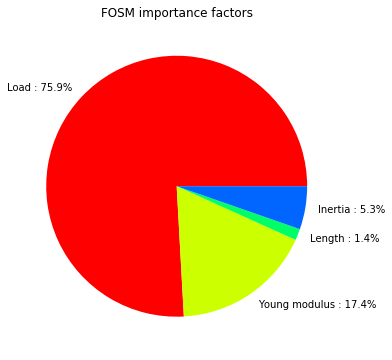

In [37]:
FOSM_importance_factors = FOSM_approximation.getImportanceFactors()
FOSM_importance_factors_graph = FOSM_approximation.drawImportanceFactors()
FOSM_importance_factors_graph.setTitle('FOSM importance factors')
_ = View(FOSM_importance_factors_graph, figure=pl.figure(figsize=(6, 6)))

## Graphical sensitivity analysis

Let's get the cached function calls... and concatenate all sample together.

In [38]:
cached_inputs = model.getCacheInput()
cached_outputs = model.getCacheOutput()

all_sample = cached_inputs[:]
all_sample.stack(cached_outputs)
all_sample.setDescription(model.getDescription())

... And make **scatter plots** out of it:

/gpfslocal/pub/python/anaconda/Anaconda2-4.3.1/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


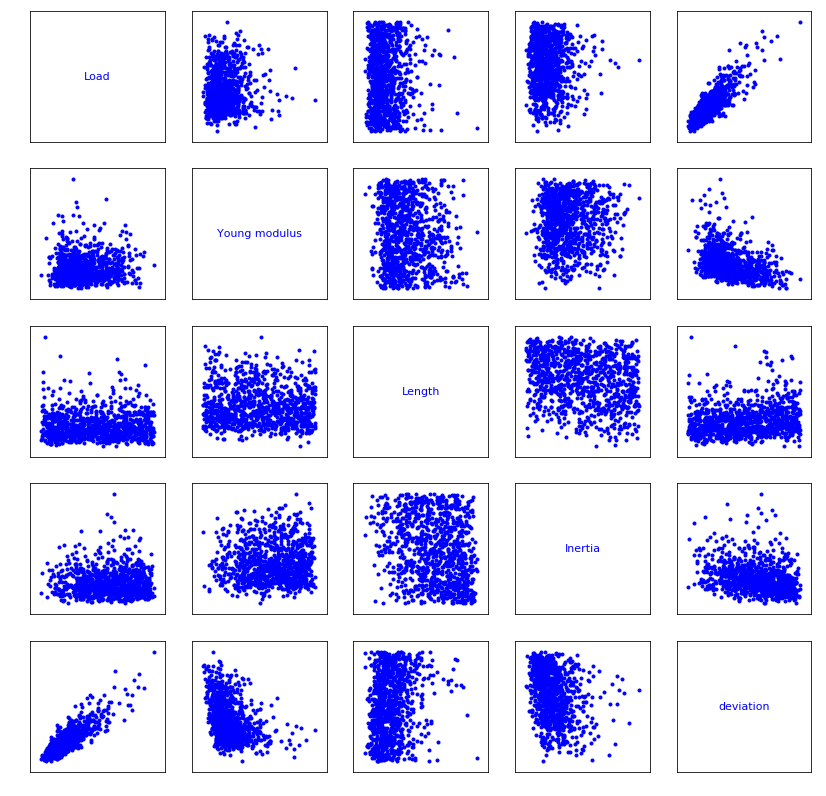

In [39]:
fig, ax = plt.subplots(figsize=(14, 14))
View(ot.Pairs(all_sample), plot_kwargs={'marker':'.'}, axes=[ax])
fig.show()

... Or a **Cobweb plot**:

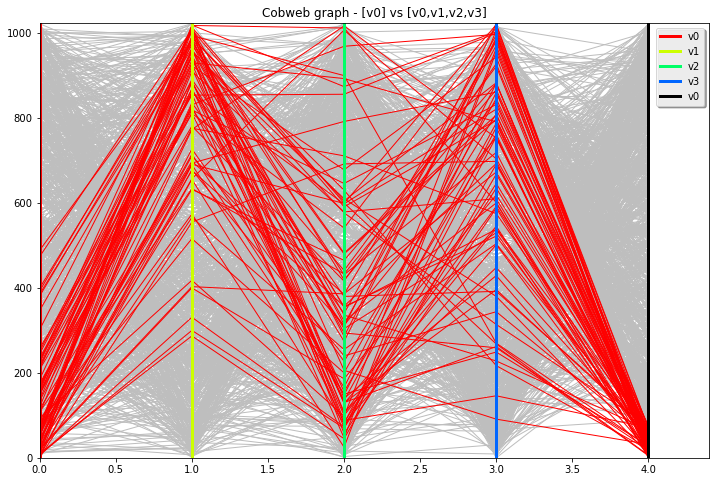

In [40]:
cobweb_plot = ot.VisualTest_DrawCobWeb(cached_inputs, cached_outputs, 28., 31., 'red', False)
cobweb_plot = ot.VisualTest_DrawCobWeb(cached_inputs, cached_outputs, 2., 8.,'red', False)
#cobweb_plot = ot.VisualTest_DrawCobWeb(cached_inputs, cached_outputs, Y_mean - 0.1 * Y_stdv, Y_mean + 0.1 * Y_stdv, 'red', False)
_ = View(cobweb_plot, figure=pl.figure(figsize=(12, 8)))